# Demand Forecasting and Supply Planning App

Demand Forecast Process
- Get sales data
- Map and model hierarchies
- Select set of forecasting algorithms to try
- Train on section of sales data
- Crossvalidation
- Select best forecasts for each series
- Make forecasts
- Reconcile hierarchies
- Return demand forecasts

Supply Planning Process
- Get inventory data and demand forecasts
- Get difference between current inventory and forecasted demand
- Calculate amount needed to meet expected demand
- Return supply recommendation

In [1]:
import pandas as pd
import numpy as np
from utilsforecast.losses import mse, rmse, mae, mape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExponentiallyWeightedMean
from mlforecast.target_transforms import LocalStandardScaler, Differences
from mlforecast.auto import AutoLightGBM, AutoMLForecast
import time
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    SeasonalNaive,
    SeasonalWindowAverage,
    CrostonClassic,
    CrostonOptimized,
    HistoricAverage,
    Naive,
    AutoETS,
    AutoCES,
    AutoMFLES
)
import optuna
import lightgbm as lgb

In [2]:
df = pd.read_csv(r"C:\Users\bwynd\allocation_tool\test_input_data.csv")

In [3]:
df

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date
0,0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...,...
58327365,58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-04-24
58327366,58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327367,58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327368,58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,3,2016-04-24


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date
0,0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...,...
58327365,58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-04-24
58327366,58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327367,58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327368,58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,3,2016-04-24


In [5]:
#fiscal_year = pd.read_csv(r"C:\Users\bwynd\OneDrive\Desktop\demand_supply_planning_app\fiscal_calendar_forecasting.csv")

In [6]:
#fiscal_year = fiscal_year[['day_date','fiscal_week_of_year','fiscal_day_of_week']]

In [7]:
#fiscal_year['day_date'] = pd.to_datetime(fiscal_year['day_date'])

In [8]:
#df = df.merge(fiscal_year, how='left', left_on='date',right_on='day_date')

In [6]:
df

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date
0,0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...,...
58327365,58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-04-24
58327366,58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327367,58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327368,58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,3,2016-04-24


In [7]:
df = df.groupby(['state_id','store_id','cat_id','dept_id','item_id', pd.Grouper(key='date', freq='W-SUN')])['Sales'].sum().reset_index().sort_values('date')

In [8]:
df.rename(columns={'Sales':'y','date':'ds'},inplace=True)

In [9]:
df

,state_id,store_id,cat_id,dept_id,item_id,ds,y
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,2011-01-30,3
5755644,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_179,2011-01-30,1
5755370,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_178,2011-01-30,0
363872,CA,CA_1,FOODS,FOODS_3,FOODS_3_717,2011-01-30,0
5755096,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_177,2011-01-30,0
...,...,...,...,...,...,...,...
5550417,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_110,2016-04-24,0
5550691,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_111,2016-04-24,2
5550965,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_112,2016-04-24,2
5547677,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_100,2016-04-24,6


In [10]:
df['date_count'] = df.groupby('ds').ngroup() + 1

In [11]:
df['total'] = 'total'

In [12]:
df['ds'] = df['date_count']
df.drop(columns='date_count', inplace=True)

In [13]:
df

,state_id,store_id,cat_id,dept_id,item_id,ds,y,total
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,1,3,total
5755644,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_179,1,1,total
5755370,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_178,1,0,total
363872,CA,CA_1,FOODS,FOODS_3,FOODS_3_717,1,0,total
5755096,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_177,1,0,total
...,...,...,...,...,...,...,...,...
5550417,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_110,274,0,total
5550691,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_111,274,2,total
5550965,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_112,274,2,total
5547677,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_100,274,6,total


In [13]:
df.to_csv('training_data_nonhierarchical.csv')

In [14]:
hierarchy_levels = [['total'],
                    ['total','state_id'],
                    ['total','state_id','store_id'],
                    ['total','state_id','store_id','cat_id'],
                    ['total','state_id','store_id','cat_id','dept_id'],
                    ['total','state_id','store_id','cat_id','dept_id','item_id']]

In [15]:
Y_hier_df, S_df, tags = aggregate(df=df, spec=hierarchy_levels)
Y_hier_df = Y_hier_df.reset_index()

In [16]:
Y_hier_df

,unique_id,ds,y
0,total,1,64380
1,total,2,196230
2,total,3,193715
3,total,4,172328
4,total,5,166645
...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,0
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,0
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,0
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,0


In [132]:
Y_hier_df.to_csv("hierarchical_df_training.csv")

In [17]:
S_df

,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_002,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_003,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_004,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_005,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_006,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_008,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_009,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_010,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_011,...,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_507,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_508,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_509,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_510,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_511,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_512,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_513,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_514,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_515,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516
total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
total/CA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total/TX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total/WI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
total/CA/CA_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
tags

{'total': array(['total'], dtype=object),
 'total/state_id': array(['total/CA', 'total/TX', 'total/WI'], dtype=object),
 'total/state_id/store_id': array(['total/CA/CA_1', 'total/CA/CA_2', 'total/CA/CA_3', 'total/CA/CA_4',
        'total/TX/TX_1', 'total/TX/TX_2', 'total/TX/TX_3', 'total/WI/WI_1',
        'total/WI/WI_2', 'total/WI/WI_3'], dtype=object),
 'total/state_id/store_id/cat_id': array(['total/CA/CA_1/FOODS', 'total/CA/CA_1/HOBBIES',
        'total/CA/CA_1/HOUSEHOLD', 'total/CA/CA_2/FOODS',
        'total/CA/CA_2/HOBBIES', 'total/CA/CA_2/HOUSEHOLD',
        'total/CA/CA_3/FOODS', 'total/CA/CA_3/HOBBIES',
        'total/CA/CA_3/HOUSEHOLD', 'total/CA/CA_4/FOODS',
        'total/CA/CA_4/HOBBIES', 'total/CA/CA_4/HOUSEHOLD',
        'total/TX/TX_1/FOODS', 'total/TX/TX_1/HOBBIES',
        'total/TX/TX_1/HOUSEHOLD', 'total/TX/TX_2/FOODS',
        'total/TX/TX_2/HOBBIES', 'total/TX/TX_2/HOUSEHOLD',
        'total/TX/TX_3/FOODS', 'total/TX/TX_3/HOBBIES',
        'total/TX/TX_3/HOUSEHOL

In [19]:
bottom_array = tags['total/state_id/store_id/cat_id/dept_id/item_id']

In [20]:
Y_test_df = Y_hier_df.groupby('unique_id').tail(6)
Y_train_df = Y_hier_df.drop(Y_test_df.index)

In [21]:
Y_test_df

,unique_id,ds,y
268,total,269,287425
269,total,270,287458
270,total,271,291571
271,total,272,310767
272,total,273,296009
...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,0
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,0
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,0
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,0


# EDA

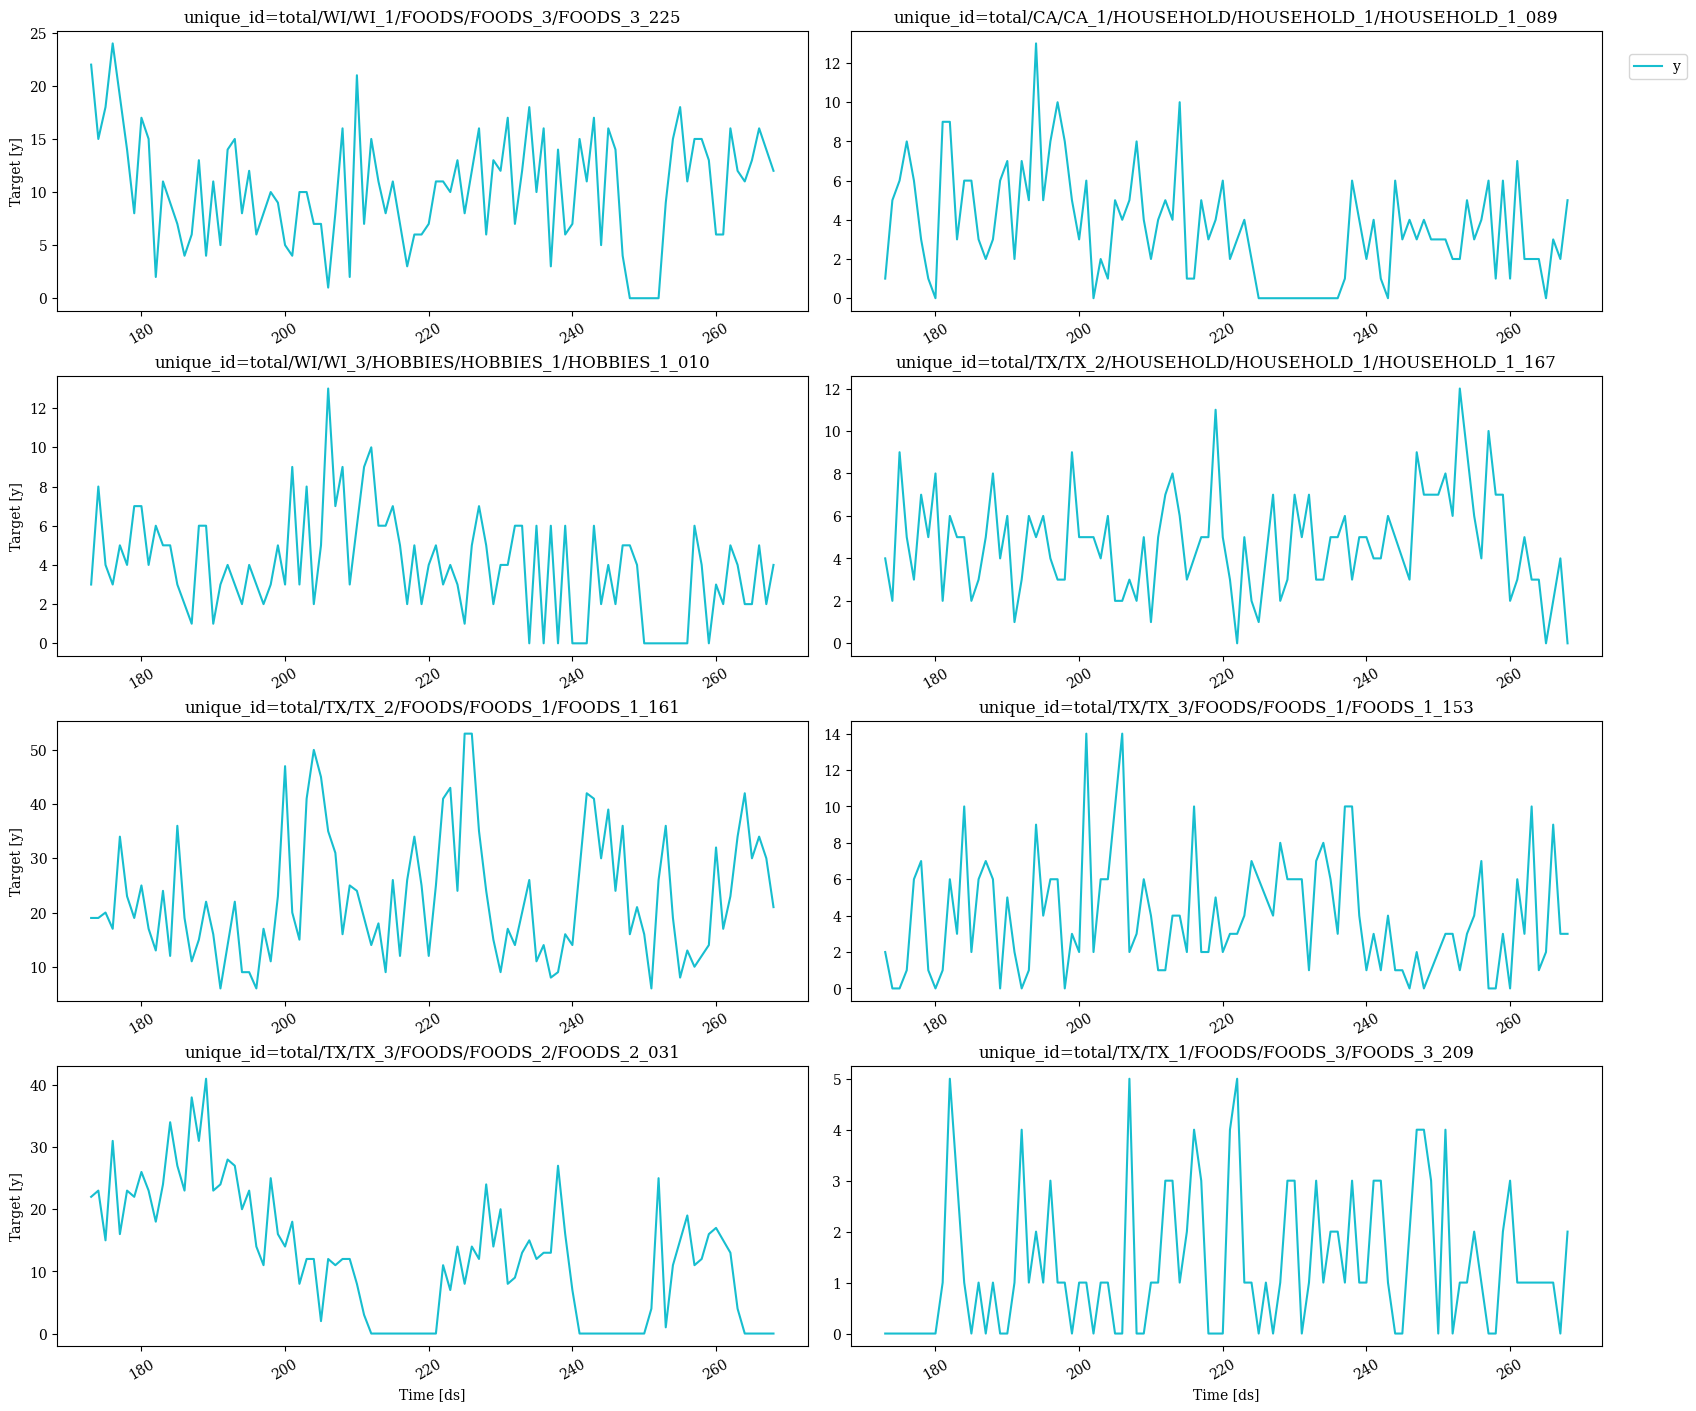

In [22]:
fig = plot_series(Y_train_df, max_insample_length=4*24)
fig

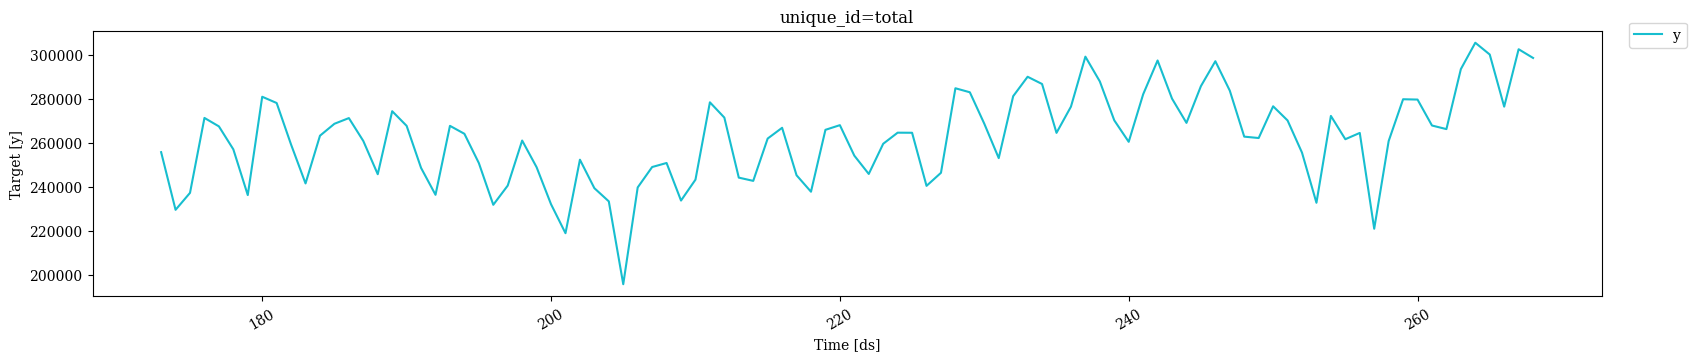

In [23]:
fig = plot_series(Y_train_df[Y_train_df['unique_id'].isin(['total'])], max_insample_length=4*24)
fig

# Feature Engineering

In [24]:
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExponentiallyWeightedMean, ExpandingStd
from mlforecast.target_transforms import LocalStandardScaler, Differences
import seaborn as sns

In [25]:
fcst = MLForecast(
    models=[],
    freq=1,
    lags=[1,2,4,52,104],
)
prep = fcst.preprocess(Y_train_df)
prep.drop(columns=['unique_id','ds']).corr()['y']

y         1.000000
lag1      0.996780
lag2      0.994295
lag4      0.997918
lag52     0.996696
lag104    0.988572
Name: y, dtype: float64

In [26]:
fcst = MLForecast(
    models=[],
    freq=1,
    lags=[1,4,52],
    lag_transforms={
        1:[RollingMean(window_size=4)],
        4:[RollingMean(window_size=4),ExponentiallyWeightedMean(alpha=.8)],
        52:[ExponentiallyWeightedMean(alpha=.8)]
    }
)
prep = fcst.preprocess(Y_train_df)
prep.drop(columns=['unique_id','ds']).corr()['y']

# lag 1
# lag 4
# lag 52
# rolling_mean_lag4_window_size4
# exponentially weighted mean lag4 alpha 0.8
# exponentially_weighted_mean_lag52_alpha0.8
# rolling_mean_lag1_window_size4

y                                             1.000000
lag1                                          0.996537
lag4                                          0.997824
lag52                                         0.993169
rolling_mean_lag1_window_size4                0.997483
rolling_mean_lag4_window_size4                0.996767
exponentially_weighted_mean_lag4_alpha0.8     0.998102
exponentially_weighted_mean_lag52_alpha0.8    0.993248
Name: y, dtype: float64

In [27]:
corr = prep.drop(columns=['unique_id','ds']).corr()

In [28]:
corr

,y,lag1,lag4,lag52,rolling_mean_lag1_window_size4,rolling_mean_lag4_window_size4,exponentially_weighted_mean_lag4_alpha0.8,exponentially_weighted_mean_lag52_alpha0.8
y,1.000000,0.996537,0.997824,0.993169,0.997483,0.996767,0.998102,0.993248
lag1,0.996537,1.000000,0.994677,0.989704,0.998019,0.997295,0.995886,0.990959
lag4,0.997824,0.994677,1.000000,0.992697,0.998001,0.997993,0.999867,0.992662
lag52,0.993169,0.989704,0.992697,1.000000,0.991571,0.991521,0.992881,0.999830
rolling_mean_lag1_window_size4,0.997483,0.998019,0.998001,0.991571,1.000000,0.999310,0.998548,0.992276
rolling_mean_lag4_window_size4,0.996767,0.997295,0.997993,0.991521,0.999310,1.000000,0.998745,0.992280
exponentially_weighted_mean_lag4_alpha0.8,0.998102,0.995886,0.999867,0.992881,0.998548,0.998745,1.000000,0.993052
exponentially_weighted_mean_lag52_alpha0.8,0.993248,0.990959,0.992662,0.999830,0.992276,0.992280,0.993052,1.000000


<Axes: >

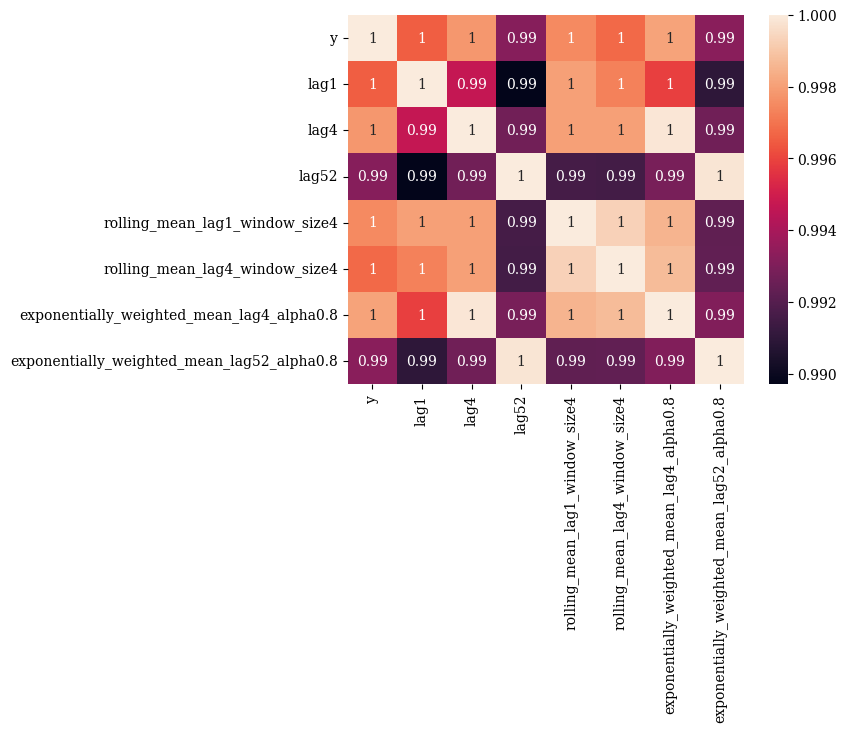

In [29]:
sns.heatmap(corr, annot=True)
# lag 1
# lag 4
# lag 52
# rolling_mean_lag4_window_size4|
# exponentially weighted mean lag4 alpha 0.8
# exponentially_weighted_mean_lag52_alpha0.8
# rolling_mean_lag1_window_size4

# Fortuna Optimization

In [60]:
from utilsforecast.losses import mae, mse, bias, smape
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences, LocalBoxCox, LocalStandardScaler
from mlforecast.optimization import mlforecast_objective

In [31]:
h = 6
def config_fn(trial):
    candidate_lags = [
        [1],
        [4],
        [8],
        [1, 4],
        [1,4,8],
        [1,4,52],
        [1,4,8,52],
        [1,4,52,104],
        [52],
        [104],
    ]
    lag_idx = trial.suggest_categorical('lag_idx', range(len(candidate_lags)))
    candidate_lag_tfms = [
        {
            1: [RollingMean(window_size=4)]
        },
        {
            1: [RollingMean(window_size=4)],
            4: [RollingMean(window_size=4)],
        },
        {
            4: [RollingMean(window_size=4)],
        },
        {
            4: [ExpandingMean(), RollingMean(window_size=4)],
            8: [ExpandingMean(), RollingMean(window_size=4)],
        }
    ]
    lag_tfms_idx = trial.suggest_categorical('lag_tfms_idx', range(len(candidate_lag_tfms)))
    return {
        'model_params': {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
            'objective': trial.suggest_categorical('objective',['l1','l2','tweedie']),
            'num_threads': -1,
            'verbose': -1,
            'force_col_wise': True,
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),            
            'num_leaves': trial.suggest_int('num_leaves', 31, 1024, log=True),
        },
        'mlf_init_params': {
            'lags': candidate_lags[lag_idx],
            'lag_transforms': candidate_lag_tfms[lag_tfms_idx],
        },
        'mlf_fit_params': {
            'static_features': ['unique_id'],
        }
    }

def loss(df, train_df):
    return mae(df, models=['model'])['model'].mean()

In [ ]:
['learning_rate','objective','n_estimators','num_leaves','lag_idx','lag_tfms_idx']

In [32]:
Y_train_df['unique_id'] = Y_train_df['unique_id'].astype('category')
Y_train_df['ds'] = Y_train_df['ds'].astype('int')

In [33]:
Y_train_df

,unique_id,ds,y
0,total,1,64380
1,total,2,196230
2,total,3,193715
3,total,4,172328
4,total,5,166645
...,...,...,...
8385485,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,264,0
8385486,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,265,0
8385487,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,266,1
8385488,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,267,0


In [34]:
start_time = time.time()
optuna.logging.set_verbosity(optuna.logging.WARNING)
objective = mlforecast_objective(
    df=Y_train_df,
    config_fn=config_fn,
    loss=loss,    
    model=lgb.LGBMRegressor(),
    freq=1,
    n_windows=3,
    h=h,
)
study = optuna.create_study(
    direction='minimize', sampler=optuna.samplers.TPESampler(seed=0)
)
study.optimize(objective, n_trials=50)
best_cfg = study.best_trial.user_attrs['config']
final_model = MLForecast(
    models=[lgb.LGBMRegressor(**best_cfg['model_params'])],
    freq=1,
    **best_cfg['mlf_init_params'],
)
final_model.fit(Y_train_df, **best_cfg['mlf_fit_params'])
preds = final_model.predict(h)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7612.8972499370575 seconds ---


In [35]:
study.best_trial

FrozenTrial(number=33, state=1, values=[7.409122904895177], datetime_start=datetime.datetime(2024, 11, 23, 15, 32, 48, 461970), datetime_complete=datetime.datetime(2024, 11, 23, 15, 34, 32, 950331), params={'lag_idx': 7, 'lag_tfms_idx': 3, 'learning_rate': 0.015854108355293578, 'objective': 'l2', 'n_estimators': 677, 'num_leaves': 167}, user_attrs={'config': {'model_params': {'learning_rate': 0.015854108355293578, 'objective': 'l2', 'num_threads': -1, 'verbose': -1, 'force_col_wise': True, 'n_estimators': 677, 'num_leaves': 167}, 'mlf_init_params': {'lags': [1, 4, 52, 104], 'lag_transforms': {4: [ExpandingMean(), RollingMean(window_size=4)], 8: [ExpandingMean(), RollingMean(window_size=4)]}}, 'mlf_fit_params': {'static_features': ['unique_id']}}}, system_attrs={}, intermediate_values={0: 6.5608693504517905, 1: 7.222154524867512, 2: 8.444344839366229}, distributions={'lag_idx': CategoricalDistribution(choices=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)), 'lag_tfms_idx': CategoricalDistribution(choic

In [131]:
optuna.visualization.plot_optimization_history(study)

In [38]:
optuna.visualization.plot_parallel_coordinate(study)

In [40]:
optuna.visualization.plot_timeline(study)

In [41]:
optuna.visualization.plot_slice(study, params=['learning_rate','objective','n_estimators','num_leaves','lag_idx','lag_tfms_idx'])

In [42]:
preds

,unique_id,ds,LGBMRegressor
0,total,269,258248.311253
1,total,270,258248.311253
2,total,271,258248.311253
3,total,272,258248.311253
4,total,273,258248.311253
...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,1.468271
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,1.468271
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,1.468271
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,1.468271


In [43]:
start_time = time.time()
crossval_ml = final_model.cross_validation(
    df=Y_train_df,
    h=6,
    step_size=1,
    n_windows=15
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 524.7696490287781 seconds ---


In [44]:
crossval_ml.reset_index(inplace=True)

In [45]:
crossval_ml

,index,unique_id,ds,cutoff,y,LGBMRegressor
0,0,total,249,248,262161,185702.531414
1,1,total,250,248,276604,185702.531414
2,2,total,251,248,270161,185702.531414
3,3,total,252,248,255509,185702.531414
4,4,total,253,248,232692,185702.531414
...,...,...,...,...,...,...
2754355,2754355,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,264,262,0,1.438467
2754356,2754356,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,265,262,0,1.390244
2754357,2754357,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,266,262,1,1.389905
2754358,2754358,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,267,262,0,1.381815


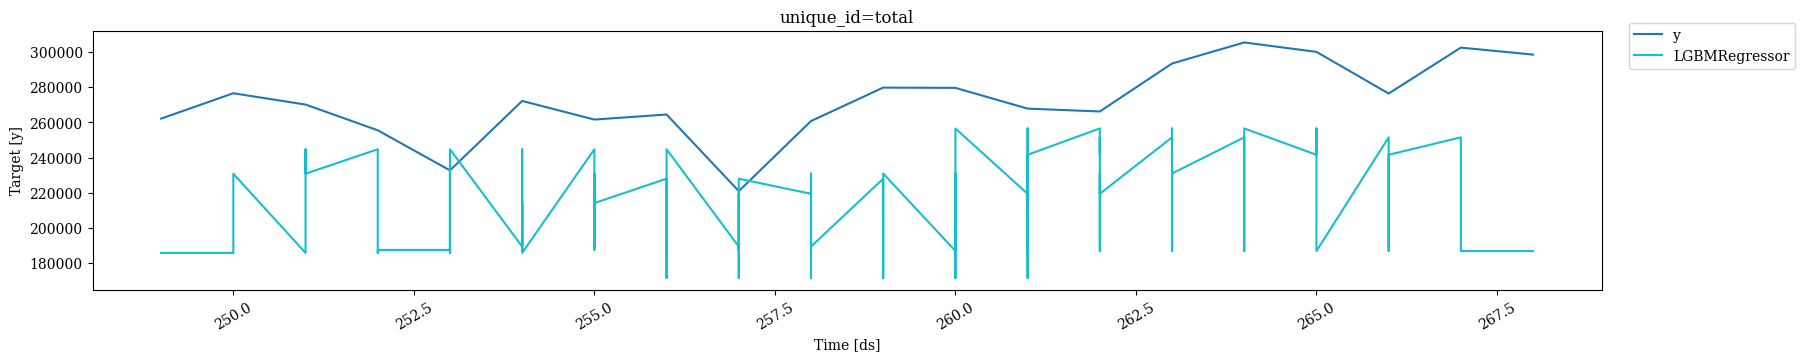

In [46]:
fig = plot_series(forecasts_df=crossval_ml[crossval_ml['unique_id'] == 'total'].drop(columns=['cutoff','index']))
fig

In [57]:
rmse(crossval_ml, models=['LGBMRegressor'], id_col='cutoff').set_index('cutoff').mean()

LGBMRegressor    473.681488
dtype: float64

In [50]:
mae(crossval_ml, models=['LGBMRegressor'], id_col='cutoff').set_index('cutoff')

,LGBMRegressor
cutoff,
248,11.152246
249,9.737771
250,7.723834
251,11.002531
252,10.936326
253,8.451411
254,9.688832
255,11.786044
256,9.390988


In [61]:
smape(crossval_ml, models=['LGBMRegressor'], id_col='cutoff').set_index('cutoff')

,LGBMRegressor
cutoff,
248,0.403800
249,0.406319
250,0.405105
251,0.412145
252,0.413502
253,0.411872
254,0.411274
255,0.410176
256,0.409049


In [52]:
mse(crossval_ml, models=['LGBMRegressor'], id_col='cutoff').set_index('cutoff')

,LGBMRegressor
cutoff,
248,373792.411010
249,224376.919496
250,36542.320240
251,360605.303329
252,364699.594790
253,107493.290024
254,295419.474814
255,444969.427911
256,250074.294334


In [58]:
473.681488 / Y_hier_df['y'].max()

0.0015242335511814317

# Statistical Methods

In [68]:
season_len = 52

In [69]:
models = [Naive(),
          SeasonalNaive(season_length=season_len),
          HistoricAverage(),
          SeasonalWindowAverage(season_length=season_len,window_size=4, alias="seasonal_window_avg_4"),
          SeasonalWindowAverage(season_length=season_len, window_size=8, alias="seasonal_window_avg_8"),
          CrostonClassic(),
          CrostonOptimized(),
          HoltWinters(season_length=season_len, error_type="A", alias="HoltWinters Add"),
          HoltWinters(season_length=season_len, error_type="M", alias="HoltWinters Multi"),
          AutoCES(season_length=season_len),
          AutoETS(model=["A","Z","N"], alias="AutoETS", season_length=season_len),
         ]

In [70]:
sf = StatsForecast(
    models=models,
    freq=1,
    fallback_model= SeasonalNaive(season_length=season_len),
    n_jobs=-1
)

In [71]:
start_time = time.time()
Y_hat_stats = sf.forecast(h=6, df=Y_train_df, fitted=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 723.19713306427 seconds ---


C:\Users\bwynd\anaconda3\envs\demand_forecaster\Lib\site-packages\statsforecast\core.py:494: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



In [88]:
Y_hat_stats

,ds,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
unique_id,,,,,,,,,,,,
total,269,298607.0,245218.0,238570.515625,245218.0,245218.0,280328.718750,292847.031250,251995.968750,247933.640625,278520.062500,290960.468750
total,270,298607.0,237725.0,238570.515625,237725.0,237725.0,280328.718750,292847.031250,249598.843750,250321.437500,276865.531250,290960.468750
total,271,298607.0,265895.0,238570.515625,265895.0,265895.0,280328.718750,292847.031250,279510.843750,280122.031250,306501.031250,290960.468750
total,272,298607.0,268017.0,238570.515625,268017.0,268017.0,280328.718750,292847.031250,274499.593750,273528.093750,301709.687500,290960.468750
total,273,298607.0,254146.0,238570.515625,254146.0,254146.0,280328.718750,292847.031250,258750.906250,253903.859375,286047.250000,290960.468750
...,...,...,...,...,...,...,...,...,...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,270,1.0,2.0,0.910448,2.0,2.0,0.714084,0.714084,1.062568,2.000000,0.787269,0.875765
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,271,1.0,0.0,0.910448,0.0,0.0,0.714084,0.714084,0.500672,0.000000,0.243564,0.875640
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,272,1.0,1.0,0.910448,1.0,1.0,0.714084,0.714084,0.537309,1.000000,0.275463,0.875536


In [72]:
start_time = time.time()
Y_fitted_df = sf.forecast_fitted_values()
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\bwynd\anaconda3\envs\demand_forecaster\Lib\site-packages\statsforecast\core.py:494: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



--- 0.6490201950073242 seconds ---


In [73]:
Y_fitted_df

,ds,y,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
unique_id,,,,,,,,,,,,,
total,1,64380.0,NaN,NaN,238570.515625,NaN,NaN,NaN,NaN,137764.468750,151858.984375,131175.953125,152947.640625
total,2,196230.0,64380.0,NaN,238570.515625,NaN,NaN,64380.000000,64380.000000,155558.000000,168685.671875,138792.062500,130644.343750
total,3,193715.0,196230.0,NaN,238570.515625,NaN,NaN,77565.000000,77565.000000,176293.125000,178947.859375,171349.859375,147160.265625
total,4,172328.0,193715.0,NaN,238570.515625,NaN,NaN,89180.000000,130869.000000,176264.781250,175893.125000,175329.109375,158883.781250
total,5,166645.0,172328.0,NaN,238570.515625,NaN,NaN,97494.796875,143306.703125,158021.859375,167532.546875,156936.937500,162269.328125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,264,0.0,1.0,0.0,0.910448,0.0,0.0,0.827745,0.827745,0.098525,0.000000,-0.020174,0.876947
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,265,0.0,0.0,2.0,0.910448,2.0,2.0,0.827745,0.827745,1.048990,2.000000,0.926981,0.876729
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,266,1.0,0.0,0.0,0.910448,0.0,0.0,0.827745,0.827745,1.286464,0.000000,1.052683,0.876460


In [74]:
start_time = time.time()
crossval_stats = sf.cross_validation(
    df=Y_train_df,
    h=6,
    step_size=1,
    n_windows=15
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5273.042569160461 seconds ---


C:\Users\bwynd\anaconda3\envs\demand_forecaster\Lib\site-packages\statsforecast\core.py:494: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



# Selecting Models

In [75]:
crossval_merged = crossval_stats.merge(crossval_ml, how='inner', left_on=['unique_id','ds','cutoff'],right_on=['unique_id','ds','cutoff']).drop(columns=['y_y','index']).rename(columns={'y_x':'y'})

In [76]:
crossval_merged

,unique_id,ds,cutoff,y,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS,LGBMRegressor
0,total,249,248,262161.0,262793.0,240512.0,235844.296875,233775.25,NaN,276773.37500,278269.59375,257172.484375,258181.750000,279595.718750,279011.031250,185702.531414
1,total,250,248,276604.0,262793.0,261019.0,235844.296875,242501.75,NaN,276773.37500,278269.59375,265588.531250,266219.968750,288494.781250,279011.031250,185702.531414
2,total,251,248,270161.0,262793.0,248876.0,235844.296875,230311.00,NaN,276773.37500,278269.59375,253069.203125,252499.156250,276344.593750,279011.031250,185702.531414
3,total,252,248,255509.0,262793.0,232014.0,235844.296875,210093.50,NaN,276773.37500,278269.59375,233265.171875,228953.500000,256135.828125,279011.031250,185702.531414
4,total,253,248,232692.0,262793.0,218848.0,235844.296875,209256.50,NaN,276773.37500,278269.59375,232485.765625,229909.390625,255315.515625,279011.031250,185702.531414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754355,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,264,262,0.0,0.0,0.0,0.919847,0.25,NaN,0.94347,0.94347,0.099043,0.000000,0.030923,0.883349,1.438467
2754356,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,265,262,0.0,0.0,2.0,0.919847,1.25,NaN,0.94347,0.94347,1.071247,2.000000,0.973346,0.883268,1.390244
2754357,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,266,262,1.0,0.0,0.0,0.919847,1.50,NaN,0.94347,0.94347,1.301456,0.000000,1.201815,0.883200,1.389905
2754358,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,267,262,0.0,0.0,1.0,0.919847,1.50,NaN,0.94347,0.94347,1.500409,1.000000,1.382549,0.883143,1.381815


In [77]:
# https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html#select-the-best-model-for-every-unique-series
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [84]:
evaluation_df = evaluate_cross_validation(crossval_merged, rmse)

C:\Users\bwynd\AppData\Local\Temp\ipykernel_26004\3478486248.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [90]:
evaluation_df

,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS,LGBMRegressor,best_model
unique_id,,,,,,,,,,,,,
total,24204.783203,27628.845703,37619.812500,39466.582031,NaN,23466.087891,24148.681641,20488.386719,20773.707031,13702.417969,24498.210938,57563.231473,CES
total/CA,9094.736328,12544.796875,13431.697266,16211.721680,NaN,9619.512695,9991.498047,8224.577148,8326.332031,5662.322754,10210.014648,52109.140045,CES
total/CA/CA_1,2130.708496,1097.458618,2067.047363,2450.980225,NaN,2331.343750,2190.034668,1394.085815,1818.348755,1602.545410,2426.314941,1993.551539,SeasonalNaive
total/CA/CA_1/FOODS,1523.261475,1793.198486,1539.986206,1268.085327,NaN,1886.619751,1723.610474,1832.099487,2146.915771,1547.963257,1918.617188,1580.068614,seasonal_window_avg_4
total/CA/CA_1/FOODS/FOODS_1,502.773102,463.491547,363.534790,196.458633,NaN,381.724060,410.371948,358.783691,410.643494,219.129135,431.605347,352.816408,seasonal_window_avg_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_512,1.382610,1.335302,1.398471,1.563314,NaN,1.304289,1.304289,1.445666,1.335302,1.494534,1.305448,1.308134,CrostonClassic
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_513,2.691939,3.384957,2.090432,2.323681,NaN,2.321446,2.217902,2.587498,3.384957,7.519323,2.304126,2.262473,HistoricAverage
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_514,0.586894,0.817751,0.687587,0.827333,NaN,0.527097,0.524114,0.686604,0.817751,0.684434,0.527401,1.146521,CrostonOptimized


In [86]:
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

In [87]:
summary_df

,0
best_model,
HoltWinters Multi,39
CES,1382
SeasonalNaive,1678
seasonal_window_avg_4,1797
AutoETS,2430
CrostonOptimized,2599
Naive,2650
HoltWinters Add,3095
LGBMRegressor,3980


In [91]:
# https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html#select-the-best-model-for-every-unique-series
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

In [93]:
preds

,unique_id,ds,LGBMRegressor
0,total,269,258248.311253
1,total,270,258248.311253
2,total,271,258248.311253
3,total,272,258248.311253
4,total,273,258248.311253
...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,1.468271
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,1.468271
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,1.468271
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,1.468271


In [94]:
Y_hat_stats

,ds,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
unique_id,,,,,,,,,,,,
total,269,298607.0,245218.0,238570.515625,245218.0,245218.0,280328.718750,292847.031250,251995.968750,247933.640625,278520.062500,290960.468750
total,270,298607.0,237725.0,238570.515625,237725.0,237725.0,280328.718750,292847.031250,249598.843750,250321.437500,276865.531250,290960.468750
total,271,298607.0,265895.0,238570.515625,265895.0,265895.0,280328.718750,292847.031250,279510.843750,280122.031250,306501.031250,290960.468750
total,272,298607.0,268017.0,238570.515625,268017.0,268017.0,280328.718750,292847.031250,274499.593750,273528.093750,301709.687500,290960.468750
total,273,298607.0,254146.0,238570.515625,254146.0,254146.0,280328.718750,292847.031250,258750.906250,253903.859375,286047.250000,290960.468750
...,...,...,...,...,...,...,...,...,...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,270,1.0,2.0,0.910448,2.0,2.0,0.714084,0.714084,1.062568,2.000000,0.787269,0.875765
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,271,1.0,0.0,0.910448,0.0,0.0,0.714084,0.714084,0.500672,0.000000,0.243564,0.875640
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,272,1.0,1.0,0.910448,1.0,1.0,0.714084,0.714084,0.537309,1.000000,0.275463,0.875536


In [95]:
Y_hat_stats.reset_index(inplace=True)

In [96]:
Y_hat_merged = preds.merge(Y_hat_stats, how='inner', left_on=['unique_id','ds'], right_on=['unique_id','ds'])

In [97]:
Y_hat_merged

,unique_id,ds,LGBMRegressor,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
0,total,269,258248.311253,298607.0,245218.0,238570.515625,245218.0,245218.0,280328.718750,292847.031250,251995.968750,247933.640625,278520.062500,290960.468750
1,total,270,258248.311253,298607.0,237725.0,238570.515625,237725.0,237725.0,280328.718750,292847.031250,249598.843750,250321.437500,276865.531250,290960.468750
2,total,271,258248.311253,298607.0,265895.0,238570.515625,265895.0,265895.0,280328.718750,292847.031250,279510.843750,280122.031250,306501.031250,290960.468750
3,total,272,258248.311253,298607.0,268017.0,238570.515625,268017.0,268017.0,280328.718750,292847.031250,274499.593750,273528.093750,301709.687500,290960.468750
4,total,273,258248.311253,298607.0,254146.0,238570.515625,254146.0,254146.0,280328.718750,292847.031250,258750.906250,253903.859375,286047.250000,290960.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,1.468271,1.0,2.0,0.910448,2.0,2.0,0.714084,0.714084,1.062568,2.000000,0.787269,0.875765
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,1.468271,1.0,0.0,0.910448,0.0,0.0,0.714084,0.714084,0.500672,0.000000,0.243564,0.875640
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,1.468271,1.0,1.0,0.910448,1.0,1.0,0.714084,0.714084,0.537309,1.000000,0.275463,0.875536
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,1.468271,1.0,1.0,0.910448,1.0,1.0,0.714084,0.714084,0.564150,1.000000,0.297056,0.875450


In [98]:
prod_forecasts_df = get_best_model_forecast(Y_hat_merged, evaluation_df)
prod_forecasts_df.head()

,unique_id,ds,best_model
0,total,269,278520.06250
1,total,270,276865.53125
2,total,271,306501.03125
3,total,272,301709.68750
4,total,273,286047.25000


In [99]:
prod_forecasts_df.set_index('unique_id',inplace=True)

In [100]:
prod_forecasts_df

,ds,best_model
unique_id,,
total,269,278520.062500
total,270,276865.531250
total,271,306501.031250
total,272,301709.687500
total,273,286047.250000
...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,270,0.875765
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,271,0.875640
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,272,0.875536


## Hierarchical Reconciliation

In [101]:
reconcilers = [TopDown(method='forecast_proportions')]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(
    Y_hat_df=prod_forecasts_df,
    Y_df=Y_hier_df,
    S=S_df, tags=tags
)

In [105]:
Y_rec_df

,ds,best_model,best_model/TopDown_method-forecast_proportions
unique_id,,,
total,269,278520.062500,278520.062500
total,270,276865.531250,276865.531250
total,271,306501.031250,306501.031250
total,272,301709.687500,301709.687500
total,273,286047.250000,286047.250000
...,...,...,...
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,270,0.875765,1.131844
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,271,0.875640,1.179547
total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_2_516,272,0.875536,0.993763


In [104]:
Y_test_df

,unique_id,ds,y
268,total,269,287425
269,total,270,287458
270,total,271,291571
271,total,272,310767
272,total,273,296009
...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,0
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,0
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,0
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,0


In [106]:
def hier_rmse(y, y_hat):
    return np.sqrt(np.mean((y-y_hat)**2))



evaluator = HierarchicalEvaluation(evaluators=[hier_rmse])
hier_eval = evaluator.evaluate(Y_hat_df=Y_rec_df, Y_test_df=Y_test_df.set_index('unique_id'), tags=tags)

In [107]:
hier_eval

,,best_model,best_model/TopDown_method-forecast_proportions
level,metric,,
Overall,hier_rmse,120.594171,111.888583
total,hier_rmse,11045.984055,11045.984055
total/state_id,hier_rmse,5399.814639,5423.404478
total/state_id/store_id,hier_rmse,2157.503202,2157.870535
total/state_id/store_id/cat_id,hier_rmse,2060.087935,1546.187401
total/state_id/store_id/cat_id/dept_id,hier_rmse,917.040793,858.246577
total/state_id/store_id/cat_id/dept_id/item_id,hier_rmse,9.668616,9.974428


In [108]:
hier_eval.to_csv('hierarchical_evaluations_summary.csv')

In [109]:
Y_rec_df.reset_index(inplace=True)

In [110]:
Y_rec_df

,unique_id,ds,best_model,best_model/TopDown_method-forecast_proportions
0,total,269,278520.062500,278520.062500
1,total,270,276865.531250,276865.531250
2,total,271,306501.031250,306501.031250
3,total,272,301709.687500,301709.687500
4,total,273,286047.250000,286047.250000
...,...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,0.875765,1.131844
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,0.875640,1.179547
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,0.875536,0.993763
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,0.875450,0.926328


In [111]:
Y_rec_df[['total','state_id','store_id','cat_id','dept_id','item_id']] = Y_rec_df['unique_id'].str.split('/', n=5, expand=True)

In [112]:
Y_rec_df = Y_rec_df.merge(evaluation_df.reset_index()[['unique_id','best_model']], how='left', left_on='unique_id', right_on='unique_id')

In [113]:
final_df = Y_rec_df[(Y_rec_df['item_id'].notna())]

In [114]:
model_breakout = final_df.groupby(by=['best_model_y']).agg({'unique_id':'count','best_model/TopDown_method-forecast_proportions':'sum'})

In [115]:
final_df

,unique_id,ds,best_model_x,best_model/TopDown_method-forecast_proportions,total,state_id,store_id,cat_id,dept_id,item_id,best_model_y
684,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,269,5.425373,4.958119,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,HistoricAverage
685,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,270,5.425373,5.025609,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,HistoricAverage
686,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,271,5.425373,8.100905,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,HistoricAverage
687,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,272,5.425373,5.523504,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,HistoricAverage
688,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,273,5.425373,5.803058,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,HistoricAverage
...,...,...,...,...,...,...,...,...,...,...,...
183619,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,0.875765,1.131844,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516,AutoETS
183620,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,0.875640,1.179547,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516,AutoETS
183621,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,0.875536,0.993763,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516,AutoETS
183622,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,0.875450,0.926328,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516,AutoETS


In [116]:
model_breakout

,unique_id,best_model/TopDown_method-forecast_proportions
best_model_y,,
AutoETS,14574,126102.179688
CES,8064,126692.617188
CrostonClassic,33966,302156.281250
CrostonOptimized,15576,150029.171875
HistoricAverage,31680,199791.296875
HoltWinters Add,18504,163268.046875
HoltWinters Multi,186,7667.064453
LGBMRegressor,23802,297112.625000
Naive,15888,139044.546875


In [117]:
final_df.to_csv('forecasted_values.csv')

In [118]:
model_breakout.to_csv('forecast_model_breakout.csv')

## Supply Planning

In [119]:
df

,state_id,store_id,cat_id,dept_id,item_id,ds,y,total
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,1,3,total
5755644,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_179,1,1,total
5755370,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_178,1,0,total
363872,CA,CA_1,FOODS,FOODS_3,FOODS_3_717,1,0,total
5755096,TX,TX_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_177,1,0,total
...,...,...,...,...,...,...,...,...
5550417,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_110,274,0,total
5550691,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_111,274,2,total
5550965,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_112,274,2,total
5547677,TX,TX_3,HOBBIES,HOBBIES_2,HOBBIES_2_100,274,6,total


In [120]:
Y_hier_df

,unique_id,ds,y
0,total,1,64380
1,total,2,196230
2,total,3,193715
3,total,4,172328
4,total,5,166645
...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,0
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,0
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,0
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,0


In [121]:
# inventory 
Y_hier_df[['total','state_id','store_id','cat_id','dept_id','item_id']] = Y_hier_df['unique_id'].str.split('/', n=5, expand=True)

In [122]:
Y_hier_df

,unique_id,ds,y,total,state_id,store_id,cat_id,dept_id,item_id
0,total,1,64380,total,None,None,None,None,None
1,total,2,196230,total,None,None,None,None,None
2,total,3,193715,total,None,None,None,None,None
3,total,4,172328,total,None,None,None,None,None
4,total,5,166645,total,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516


In [123]:
supply_df = Y_hier_df[(Y_hier_df['item_id'].notna())]

In [124]:
supply_df

,unique_id,ds,y,total,state_id,store_id,cat_id,dept_id,item_id
31236,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,1,3,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
31237,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2,9,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
31238,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,3,7,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
31239,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,4,10,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
31240,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,5,14,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
...,...,...,...,...,...,...,...,...,...
8385491,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,270,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385492,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,271,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385493,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,272,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516
8385494,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,273,0,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_516


In [125]:
supply_df = pd.DataFrame(supply_df['unique_id'].drop_duplicates())

In [126]:
supply_df

,unique_id
31236,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001
31510,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_002
31784,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_003
32058,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_004
32332,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_005
...,...
8384126,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...
8384400,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...
8384674,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...
8384948,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...


In [127]:
# inventory 
supply_df[['total','state_id','store_id','cat_id','dept_id','item_id']] = supply_df['unique_id'].str.split('/', n=5, expand=True)

In [128]:
supply_df['On Hand'] = supply_df.apply(lambda x: np.random.randint(0, 20), axis=1)

In [129]:
supply_df

,unique_id,total,state_id,store_id,cat_id,dept_id,item_id,On Hand
31236,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_001,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,19
31510,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_002,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_002,12
31784,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_003,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_003,11
32058,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_004,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_004,1
32332,total/CA/CA_1/FOODS/FOODS_1/FOODS_1_005,total,CA,CA_1,FOODS,FOODS_1,FOODS_1_005,9
...,...,...,...,...,...,...,...,...
8384126,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_512,13
8384400,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_513,2
8384674,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_514,8
8384948,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_515,0


In [160]:
supply_df.to_csv('on_hand_supply_planning.csv')

In [169]:
evaluation_df.reset_index(inplace=True)

In [172]:
# evaluation_df[['total','state_id','store_id','cat_id','dept_id','item_id']] = evaluation_df['unique_id'].str.split('/', n=5, expand=True)
eval_to_csv = evaluation_df
eval_to_csv.to_csv("evaluation_data.csv")

In [171]:
evaluation_df

,index,unique_id,Naive,SeasonalNaive,HistoricAverage,seasonal_window_avg_4,seasonal_window_avg_8,CrostonClassic,CrostonOptimized,HoltWinters Add,...,tweedie,regression,l1reg,best_model,total,state_id,store_id,cat_id,dept_id,item_id
0,0,total,26689.578125,30639.666016,43046.570312,42261.457031,NaN,23216.232422,24833.277344,24103.435547,...,75683.031251,71605.864698,135853.639981,CES,total,None,None,None,None,None
1,1,total/CA,9270.109375,14490.906250,15283.909180,17235.208984,NaN,8057.638184,9024.456055,9615.675781,...,48774.134402,49379.943351,11097.287717,CES,total,CA,None,None,None,None
2,2,total/CA/CA_1,2232.298096,1024.222900,2297.759033,2665.371094,NaN,1755.579712,1885.201904,1389.937256,...,1499.330535,1548.652233,2273.481597,SeasonalNaive,total,CA,CA_1,None,None,None
3,3,total/CA/CA_1/FOODS,1707.474243,1426.662109,1321.168213,1197.351807,NaN,1434.391846,1549.976562,1526.461304,...,1217.686924,1131.080811,1716.023949,regression,total,CA,CA_1,FOODS,None,None
4,4,total/CA/CA_1/FOODS/FOODS_1,497.096771,442.665771,323.489441,219.249176,NaN,317.956696,375.055481,318.413910,...,352.561977,360.722321,429.337144,seasonal_window_avg_4,total,CA,CA_1,FOODS,FOODS_1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30599,30599,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,1.518370,1.556155,1.426331,1.776400,NaN,1.457588,1.457588,1.662779,...,1.369665,1.270895,1.482331,regression,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_512
30600,30600,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,3.034236,3.812701,2.310679,2.619705,NaN,2.401839,2.406588,2.822934,...,2.370663,2.444417,2.397921,HistoricAverage,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_513
30601,30601,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,0.493971,0.829317,0.755300,0.913158,NaN,0.538642,0.533656,0.703577,...,0.764550,1.453432,0.492106,l1reg,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_514
30602,30602,total/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2/HOUSEHOLD_...,1.243301,1.812770,1.741051,1.843493,NaN,1.441312,1.113511,1.025964,...,1.017625,0.996706,1.138976,regression,total,WI,WI_3,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_515


In [ ]:
import numpy as np
import pandas as pd

def wrmsse(actual, pred, weights):
    """
    Calculates the WRMSSE.

    Args:
        actual (pd.DataFrame): Actual values.
        pred (pd.DataFrame): Predicted values.
        weights (pd.Series): Weights for each series.
    """
    # Calculate the scaling factor
    h = 28
    n = actual.shape[0]
    scaling_factor = np.sqrt(np.sum((actual - actual.shift(h))**2) / (n - h))

    # Calculate the RMSE for each series
    rmse = np.sqrt(np.mean((actual - pred)**2, axis=0))

    # Calculate the weighted RMSE
    weighted_rmse = np.sum(weights * rmse / scaling_factor)

    return weighted_rmse